## I2A2 - Redes Generativas - 2023
### Desafio 5 - Fine-tuning em LLM Open Source

### Componentes:

*   Celso Malachias (celso.malachias@dnahunter.com.br)
*   Daniel Neto (dvn.face@gmail.com)
*   José Neto (jose.fe.neto@gmx.com)
*   Robson da Costa (robsondacosta@gmail.com)
*   Sidnei Ribeiro (jsribeiro123@gmail.com)
*   Vinícius Reis (viniciusreis@gmail.com)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


--------------------------------------------------------------------------------

Instalação das bibliotecas necessárias

In [2]:
#Se base_model for diferente de "mistralai/Mixtral-8x7B-Instruct-v0.1"
!pip install einops
!pip install transformers peft bitsandbytes trl datasets torch accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 815.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

Importação das bibliotecas necessárias

In [3]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    Trainer,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer



Definição do modelo, dataset e modelo otimizado

In [4]:
# Modelo do Hugging Face

base_model = "NousResearch/Llama-2-7b-chat-hf"
#base_model = "microsoft/phi-2"
#base_model = "mistralai/Mixtral-8x7B-Instruct-v0.1"


# Base de dados

guanaco_dataset = "mlabonne/guanaco-llama2-1k"

# Modelo treinado e otimizado

new_model = "llama-2-chat-guanaco"
#new_model = "ms-phi-2-chat-guanaco"
#new_model = "mixtral8x7B-chat-guanaco"

Carregando o dataset

In [5]:
dataset = load_dataset(guanaco_dataset, split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Definindo a técnica de quantização do modelo (Desafio Extra)

As técnicas de quantização reduzem os custos computacionais e de memória, representando pesos e ativações com tipos de dados de menor precisão, como números inteiros de 8 bits (int8). Isso permite carregar modelos maiores que você normalmente não conseguiria colocar na memória e acelerar a inferência. Transformers suporta os algoritmos de quantização AWQ e GPTQ e suporta quantização de 8 e 4 bits com BitsAndBytes.

Mais detalhes em:
https://huggingface.co/docs/transformers/main_classes/quantization

In [6]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,                    # Ativa o carregamento do modelo base de precisão de 4 bits
    bnb_4bit_quant_type="nf4",            # Tipo de quantização (fp4 ou nf4)
    bnb_4bit_compute_dtype=compute_dtype, # Calcula dtype para modelos básicos de 4 bits
    bnb_4bit_use_double_quant=True,       # Ativa a quantização aninhada para modelos básicos de 4 bits (quantização dupla)
)

Criando o tokenizador

In [7]:
tokenizer = AutoTokenizer.from_pretrained(base_model, add_eos_token=True, use_fast=True, trust_remote_code=True)
tokenizer.pad_token = tokenizer.unk_token
tokenizer.pad_token_id =  tokenizer.unk_token_id
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

Criando o modelo

In [8]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype="auto",
    trust_remote_code=True,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


Aplicando a técnica LoRA, que acelera o ajuste fino de modelos grandes consumindo menos memória. (Desafio Extra)

Para tornar o ajuste fino mais eficiente, a abordagem do LoRA é representar as atualizações de peso com duas matrizes menores (chamadas matrizes de atualização) por meio de decomposição de baixa classificação. Essas novas matrizes podem ser treinadas para se adaptarem aos novos dados, mantendo baixo o número geral de alterações. A matriz de peso original permanece congelada e não recebe mais ajustes. Para produzir os resultados finais, os pesos originais são combinados.

Mais detalhes em:
https://huggingface.co/docs/peft/conceptual_guides/lora

In [9]:
peft_params = LoraConfig(
    lora_alpha=64,          # Parâmetro para escalonamento
    lora_dropout=0.1,       # Probabilidade de abandono das camadas
    r=16,                   # Dimensão da atenção
    bias="none",            # Treinar parâmetros do bias
    task_type="CAUSAL_LM",  # Tipo usado para geração de texto
    target_modules= ['k_proj', 'q_proj', 'v_proj', 'o_proj']
)

Definindo os parâmetros para o treino

In [10]:
training_params = TrainingArguments(
    output_dir="./results",         # Diretório de saída onde as previsões e pontos de verificação do modelo serão armazenados
    num_train_epochs=1,             # Número de épocas de treinamento
    per_device_train_batch_size=4,  # Tamanho do lote por GPU para treinamento
    per_device_eval_batch_size=4,   # Tamanho do lote por GPU para avaliação
    gradient_accumulation_steps=1,  # Número de etapas de atualização dos gradientes
    gradient_checkpointing = True,  # Ativa o checkpoint do gradiente
    optim="paged_adamw_8bit",       # Otimizador utilizado
    save_steps=50,                  # Salva o ponto de verificação a cada 50 etapas de atualização
    eval_steps=50,                  # Número de etapas de atualização entre duas avaliações
    logging_steps=50,               # Registra todas as etapas de atualizações
    learning_rate=2e-5,             # Taxa de aprendizado inicial (otimizador AdamW)
    weight_decay=0.001,             # Redução de peso a ser aplicada a todas as camadas, exceto pesos de polarização/LayerNorm
    fp16=False,                     # Habilita o treinamento fp16
    bf16=False,                     # Habilita o treinamento bf16 (defina bf16 como True com um A100)
    max_grad_norm=0.3,              # Gradiente máximo (recorte de gradiente)
    warmup_steps=30,                # Número de etapas de crescimento
    max_steps=300,                  # Número de etapas de treinamento (substitui num_train_epochs)
    warmup_ratio=0.03,              # Proporção de crescimento da taxa de aprendizagem (de 0 até a taxa de aprendizagem)
    group_by_length=True,           # Agrupa sequências em lotes com o mesmo comprimento (Economiza memória e acelera consideravelmente o treinamento)
    lr_scheduler_type="linear"      # Cronograma de taxa de aprendizagem

)

Definindo o treinador de Ajuste fino supervisionado

O ajuste fino supervisionado (ou SFT, abreviadamente) é uma etapa crucial na Aprendizagem por Reforço com Feedback Humano (RLHF).

Mais detalhes em:
https://huggingface.co/docs/trl/sft_trainer

In [11]:
trainer = SFTTrainer(
    model=model,                # Modelo
    train_dataset=dataset,      # Dataset
    tokenizer=tokenizer,        # Tokenizador
    peft_config=peft_params,    # Parâmetros LoRA
    dataset_text_field="text",  # Campo texto do dataset
    args=training_params,       # Parâmetros de treinamento
    max_seq_length=None,        # Comprimento máximo da sequência a ser usada
    packing=False               # Reúne vários exemplos curtos na mesma sequência de entrada para aumentar a eficiência
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:222: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Salvando o modelo treinado e o tokenizador

In [12]:
trainer.model.save_pretrained(new_model)
trainer.tokenizer.save_pretrained(new_model)

('llama-2-chat-guanaco/tokenizer_config.json',
 'llama-2-chat-guanaco/special_tokens_map.json',
 'llama-2-chat-guanaco/tokenizer.json')

Definindo o prompr de sistema com a diretrizes do assistente

In [13]:
#system_prompt = "Você é um assistente prestativo, respeitoso e honesto. Sempre responda da maneira mais prestativa possível. Suas respostas não devem incluir conteúdo prejudicial, antiético, racista, sexista, tóxico, perigoso ou ilegal. Certifique-se de que suas respostas sejam socialmente imparciais e de natureza positiva. Se uma pergunta não fizer sentido ou não for coerente, explique o porquê, em vez de responder algo incorreto. Se você não sabe a resposta de uma pergunta, não compartilhe informações falsas. Responda somente na língua português do Brasil (pt-br).
#system_prompt = "Você é um assistente prestativo, respeitoso e honesto. Se uma pergunta não fizer sentido ou não for coerente, explique o porquê, em vez de responder algo incorreto. Responda somente na língua português do Brasil (pt-br)."
system_prompt = "Responda somente na língua português do Brasil (pt-br)."

Definindo o pipeline e seus parâmetros

Exemplo recomendado no wiki do hugging face:

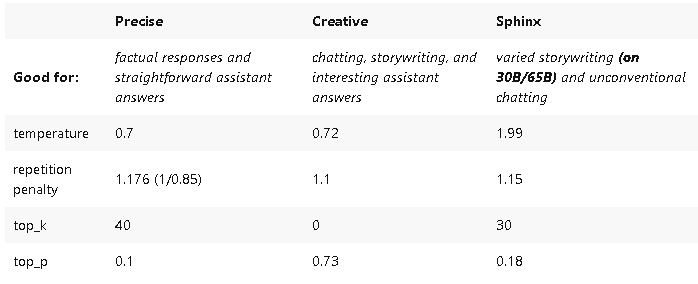

In [14]:
logging.set_verbosity(logging.CRITICAL)
gerador_texto = pipeline(
    task="text-generation",   # Tipo da tarefa
    model=model,              # Modelo treinado
    tokenizer=tokenizer,      # Tokenizador
    do_sample=False,          # Permite estratégias de decodificação, como amostragem multinomial
    max_new_tokens=1000,      # Número máximo de tokens novos na resposta
    temperature=0.72,         # Valores entre 0.0 e 1.0
    repetition_penalty=1.1,   # Sem este parâmetro, a saída fica se repetindo
    top_k=0,                  # Valores entre 0.0 e *.*
    top_p=0.73                # Valores entre 0.0 e 1.0
)

Realizando testes

In [15]:
prompt = "Quem foi o Leonardo Da Vinci? O que ele fez?"
resultado = gerador_texto(f"<s>[INST] <<SYS>> {system_prompt} <</SYS>> {prompt} [/INST]")
print(resultado[0]['generated_text'].replace(f"<<SYS>> {system_prompt} <</SYS>>", ""))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.72` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.73` -- this flag is only used in sample-based generation modes. You should s

<s>[INST]  Quem foi o Leonardo Da Vinci? O que ele fez? [/INST]  Oh, você quer saber quem foi Leonardo da Vinci e o que ele fez? 😊
 Unterscheidung! 🎨

Leonardo da Vinci (1452-1519) foi um artista, engenheiro, matemático, anatomista e inventor italiano, considerado um dos mais grandes genios da história. Ele nasceu em Vinci, uma pequena cidade da Toscana, e viveu durante a Renascença. 🇮🇹

Leonardo foi um pintor, desenhador e escultor, e suas obras são consideradas some of the most famous and influential in the history of art. Ele criou o famoso "Mona Lisa" (também conhecida como "Lady with an Ermine"), além de outras obras como "The Last Supper", "Virgin of the Rocks" e "Lady with an Ermine". 🎨

Além disso, Leonardo também foi um prolífico inventor e engenheiro. Ele desenvolveu ideias pioneiras em áreas como a aviação, a engenharia mecânica e a medicina. Ele projetou aeroplanos, barcos e outros dispositivos, e estudou o movimento das criaturas e da humanidade para melhorar sua compreens

In [16]:
prompt = "Quem é Sílvio Santos?"
resultado = gerador_texto(f"<s>[INST] <<SYS>> {system_prompt} <</SYS>> {prompt} [/INST]")
print(resultado[0]['generated_text'].replace(f"<<SYS>> {system_prompt} <</SYS>>", ""))

<s>[INST]  Quem é Sílvio Santos? [/INST]  Sílvio Santos é um empresário, produtor de televisão e apresentador brasileiro. Unterscheidung between "Sílvia" and "Silvio". Sílvia is a feminine name in Portuguese, while Silvio is a masculine name.

Sílcio Santos é conhecido por ser o fundador e proprietário da emissora de televisão SBT (Sistema Brasileiro de Televisão), uma das principais emissoras de televisão do Brasil. Ele foi também um dos maiores produtores de televisão do país e apresentou vários programas em sua emissora, como "Programa Silvio" e "Fantastico". Além disso, ele também foi político e foi deputado estadual no Rio de Janeiro por alguns anos.

Sílcio Santos é considerado um dos mais importantes nomes da televisão brasileira, tendo sido pioneiro na área e tendo contribuído para o desenvolvimento da indústria no país.


In [17]:
prompt = "Quem é o atual presidente do Brasil?"
resultado = gerador_texto(f"<s>[INST] <<SYS>> {system_prompt} <</SYS>> {prompt} [/INST]")
print(resultado[0]['generated_text'].replace(f"<<SYS>> {system_prompt} <</SYS>>", ""))

<s>[INST]  Quem é o atual presidente do Brasil? [/INST]  O atual presidente do Brasil é Jair Messias Bolsonaro. Unterscheidung!


In [18]:
prompt = "Com qual base de dados você foi treinado?"
resultado = gerador_texto(f"<s>[INST] <<SYS>> {system_prompt} <</SYS>> {prompt} [/INST]")
print(resultado[0]['generated_text'].replace(f"<<SYS>> {system_prompt} <</SYS>>", ""))

<s>[INST]  Com qual base de dados você foi treinado? [/INST]  Eu, LLaMA, foi treinado com uma grande quantidade de texto disponível em línea, incluindo livros, artigos, blogs e outros tipos de conteúdo. nobody 

Meu treinamento baseou-se em uma ampla variedade de fontes de dados, incluindo:

1. Web pages: I was trained on a large corpus of web pages, including articles, blogs, and other types of content.
2. Books: I have been trained on a large collection of books, including both fiction and non-fiction works.
3. News articles: I have been trained on a large dataset of news articles from various sources, including newspapers, magazines, and online news sites.
4. Social media: I have been trained on a large dataset of social media posts, including tweets, Facebook posts, and other types of social media content.
5. Forums and discussion boards: I have been trained on a large dataset of forum and discussion board posts, including topics such as politics, sports, and entertainment.
6. Data